# Data Analysis

Data analysis often includes activities that look for patterns or signals in the data.  Advanced techniques, such as data modeling and machine learning are outside the scope of the course (but not the [Advanced Data Driven Methods Graduate certificate](https://www.sci.pitt.edu/academics/graduate-certificates/applied-data-driven-methods), which is available to all MLIS students!).  The analysis we cover are basic statistical methods.  We will cover two classes of statistics:

**Descriptive Statistics**
- Describe the data and characteristics of the data
- Examples: mean, standard deviation

**Inferential Statistics**
- Makes inferences from the data to more general conditions (e.g. population)
- Examples: hypothesis testing, point estimation


## But first, let's discuss the data used in the notebook...

The data we are using is provided by the authors of Data Wrangling with Python [\*] It is [UNICEF data](https://github.com/jackiekazil/data-wrangling/tree/master/data/unicef) published from their corpus on child labor. UNICEF has significant data sets on women and children.  This is data from Zimbabwe’s latest Multiple Indicator Cluster Survey.  This is data from survey participants that identify as men.

[\*] Jacqueline Kazil and Katharine Jarmul. 2016. Data Wrangling with Python: Tips and Tools to Make Your Life Easier (1st. ed.). O'Reilly Media, Inc.

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats  ## THIS ONE IS NEW!! SCIPY, NUMPY's scientific analysis cousin

In [3]:
df_mn = pd.read_csv('files/mn-combined.csv', low_memory=False)
df_mn

,Unnamed: 0,HH1,HH2,LN,MWM1,MWM2,MWM4,MWM5,MWM6D,MWM6M,...,MWAGE,MWDOM,MWAGEM,MWDOBLC,MMSTATUS,MCEB,MCSURV,MCDEAD,wscore,windex5
0,0,1,17,1,1,17,1,14,7,4,...,25-29,1365.0,29.0,NaN,Currently married/in union,0.0,0.0,0.0,1.603670,5
1,1,1,20,1,1,20,1,14,7,4,...,35-39,1370.0,37.0,NaN,Currently married/in union,0.0,0.0,0.0,1.543277,5
2,2,2,1,1,2,1,1,9,8,4,...,40-44,1100.0,18.0,NaN,Currently married/in union,3.0,3.0,0.0,0.878635,4
3,3,2,1,5,2,1,5,9,12,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0
4,4,2,1,8,2,1,8,9,8,4,...,20-24,NaN,NaN,NaN,Never married/in union,0.0,0.0,0.0,0.878635,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003,9003,682,20,2,682,20,2,913,11,3,...,20-24,NaN,NaN,NaN,Never married/in union,0.0,0.0,0.0,0.641895,4
9004,9004,682,20,3,682,20,3,918,10,3,...,15-19,NaN,NaN,NaN,Never married/in union,0.0,0.0,0.0,0.641895,4
9005,9005,682,21,2,682,21,2,913,13,3,...,15-19,NaN,NaN,NaN,Never married/in union,0.0,0.0,0.0,0.712168,4
9006,9006,682,23,1,682,23,1,913,9,3,...,25-29,NaN,NaN,NaN,Never married/in union,0.0,0.0,0.0,0.847591,4


The column names are useless.  The data curator did this keep them easy to use in code.  This resulted in the obscure names.  A translation between cryptic column name and a description is provided in `files/mn_headers_updated.csv`.

## Confidence Intervals and Z-Score

Let's go over some basic statistical analysis vocabulary. 

**Point Estimates** 
- Estimate the value of a variable for a population based on an inference about that population
- Example we’ll use: estimate the number of children a person has based on the average number of children in the population
- Based on a sample, estimates likely to vary

**Estimation as an interval**
- Confidence Interval: A range of values such that for the desired level there is confidence in the true value falling within
- Confidence Level: Probability of the true value being included in the interval
- Confidence Limits: Extremes of the confidence interval, the end points

Here is a picture that illustrates the above concepts:

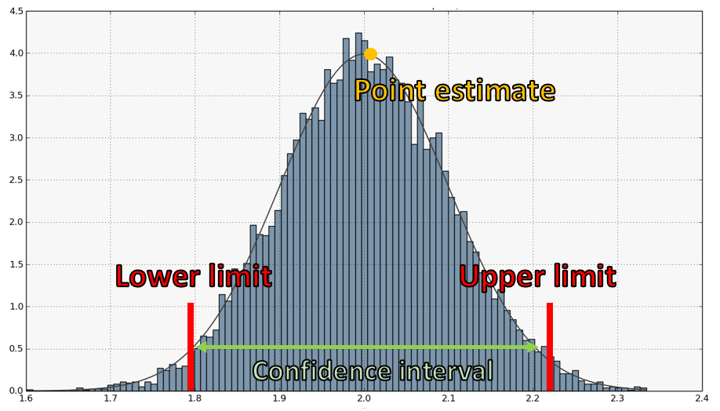

*Source: [Wikipedia](https://en.wikipedia.org/wiki/Point_estimation)*

### Describe the Data

Let's dig in to the data to get a sense of how many children the respondents reported being born.

If we select the `MCM10` column, which roughly measures the number of children born to survey respondents, we can get a sense of the average number using the `mean()` function. 

In [12]:
# Compute the average for the MCM10 column
df_mn['MCM10'].mean()

1.7738185494061158

Look at the average/mean (above) and then look at the max value (below). Are there outliers?

In [13]:
# These max values are really large, perhaps we have some outliers?
df_mn['MCM10'].max()

30.0

Let's go even deeper and look to see the number of children by age group. First, let's group by the `MWAGE` column which is the column of the survey respondent's age. Second, we will select the `MCM10` column, number of children ever born, and compute some basic *descriptive* statistics (count, mean, min, max, etc.).

In [5]:
# let's generate some simple statistics
df_mn.groupby('MWAGE')['MCM10'].describe()

,count,mean,std,min,25%,50%,75%,max
MWAGE,,,,,,,,
15-19,2025.0,0.008889,0.099007,0.0,0.0,0.0,0.0,2.0
20-24,1237.0,0.322555,0.616849,0.0,0.0,0.0,1.0,4.0
25-29,1114.0,1.154399,1.108427,0.0,0.0,1.0,2.0,7.0
30-34,1096.0,2.268248,1.593690,0.0,1.0,2.0,3.0,15.0
35-39,922.0,3.200651,1.856374,0.0,2.0,3.0,4.0,14.0
40-44,745.0,4.068456,2.292903,0.0,3.0,4.0,5.0,21.0
45-49,427.0,4.695550,2.970284,0.0,3.0,4.0,6.0,30.0
50-54,348.0,5.350575,3.004909,0.0,4.0,5.0,7.0,27.0


So now we can see that for each age group we have a mean, but then there are also max values that are WAAAAY larger than the mean. These max values are outliers and they skew our statistical calculations. 

Let's use some more statistics to remove the outliers and recompute our mean values.

## Central Limit Theorem

Let's nerd out for a moment and talk about some statistical theory...

"In probability theory, the central limit theorem establishes that, in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed." [From Wikipedia](https://en.wikipedia.org/wiki/Central_limit_theorem)



### Z-scores, and the hunt for outliers

The Z-score is the location of each sample value (X) within a distribution.

It is a number that establishes the relationship between:
- The sample value
- The mean
- The standard deviation

The number is a numerical value that specifies the distance from the mean by counting the number of standard deviations. +/- indicates direction.

Consider the following normal distribution:

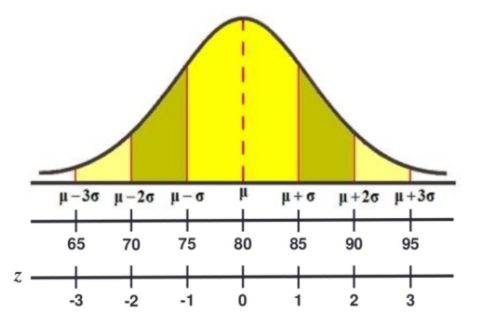

In the above distribution we can consider cases of X and the resulting Z-score...

|X|Z-score|
|---|----|
|90|2|
|75|-1|

**What is a Z-score good for?**
- Determine where on a distribution a particular score is located
- Standardized entire distributions, making them comparable
- Detecting outliers
    - Mathematically distinguish scores that are very far from the typical response
    - Systematic, adopted approach to ignoring problematic data


Now let's use python and pandas to calculate the Z-scores for the `MCM10` column (number of children ever born). We're going to slightly modify our calculation to only consider *survey respondents that have children*.  We will do this by creating a mask of `MCM10` values above 0.

In [22]:
# create a new Series from MCM10 column for values greater than 10
number_of_children = df_mn[df_mn['MCM10'] > 0]['MCM10']
# compute the zscore of respondents with children
mcm11bZS = stats.zscore(number_of_children)
mcm11bZS

2      -0.101301
6      -0.996242
8      -0.996242
10     -0.548771
13      0.346170
          ...   
8993    1.688582
8996    0.346170
8997   -0.101301
8999   -0.548771
9001   -0.101301
Name: MCM10, Length: 4351, dtype: float64

Now to make it easier, convert all values to positive scores using `np.abs()` function.

In [15]:
# compute the absolute value of all the zscores
abs_mcm11bZS = np.abs(mcm11bZS)
abs_mcm11bZS

2       0.101301
6       0.996242
8       0.996242
10      0.548771
13      0.346170
          ...   
8993    1.688582
8996    0.346170
8997    0.101301
8999    0.548771
9001    0.101301
Name: MCM10, Length: 4351, dtype: float64

Now the fun sauce... let's create mask for ***only*** values that are below a Z-score of 3. What this will do is remove the *outliers*, the values that are significantly different from the average values in the data.

In [20]:
# create a mask the filters out zscores greater than 3
filtered_mcm11bZS = (abs_mcm11bZS < 3)
filtered_mcm11bZS

2       True
6       True
8       True
10      True
13      True
        ... 
8993    True
8996    True
8997    True
8999    True
9001    True
Name: MCM10, Length: 4351, dtype: bool

In [26]:
# create a dataframe of responses with children values greater than zero
survey_responses_with_children = df_mn[df_mn['MCM10'] > 0]
# use the zscore mask to remove outliers
survey_responses_with_children_no_outliers = survey_responses_with_children[filtered_mcm11bZS]
survey_responses_with_children_no_outliers

,Unnamed: 0,HH1,HH2,LN,MWM1,MWM2,MWM4,MWM5,MWM6D,MWM6M,...,MWAGE,MWDOM,MWAGEM,MWDOBLC,MMSTATUS,MCEB,MCSURV,MCDEAD,wscore,windex5
2,2,2,1,1,2,1,1,9,8,4,...,40-44,1100.0,18.0,NaN,Currently married/in union,3.0,3.0,0.0,0.878635,4
6,6,2,7,1,2,7,1,9,12,4,...,25-29,1333.0,23.0,NaN,Currently married/in union,1.0,1.0,0.0,0.594823,4
8,8,2,11,1,2,11,1,12,7,4,...,30-34,1309.0,26.0,NaN,Currently married/in union,1.0,1.0,0.0,0.541830,4
10,10,2,14,2,2,14,2,12,13,4,...,35-39,1279.0,28.0,NaN,Formerly married/in union,2.0,2.0,0.0,1.535549,5
13,13,2,17,1,2,17,1,10,13,4,...,35-39,1199.0,23.0,NaN,Currently married/in union,4.0,4.0,0.0,0.961363,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,8993,682,3,1,682,3,1,918,16,3,...,50-54,1018.0,22.0,NaN,Currently married/in union,7.0,7.0,0.0,0.917077,4
8996,8996,682,5,1,682,5,1,922,9,3,...,35-39,1174.0,22.0,NaN,Currently married/in union,4.0,4.0,0.0,1.071216,5
8997,8997,682,8,1,682,8,1,922,10,3,...,50-54,1057.0,24.0,NaN,Currently married/in union,3.0,2.0,1.0,0.839500,4
8999,8999,682,12,1,682,12,1,918,9,3,...,20-24,1352.0,22.0,NaN,Currently married/in union,2.0,2.0,0.0,0.648918,4


OK... now let's use this DataFrame, which contains on the rows for survey participants that have children and ***are not*** outliers.

In [38]:
# summarize the updated data without outliers
survey_responses_with_children_no_outliers.groupby('MWAGE')['MCM10'].describe()

,count,mean,std,min,25%,50%,75%,max
MWAGE,,,,,,,,
15-19,17.0,1.058824,0.242536,1.0,1.0,1.0,1.0,2.0
20-24,316.0,1.262658,0.549746,1.0,1.0,1.0,1.0,4.0
25-29,727.0,1.768913,0.891633,1.0,1.0,2.0,2.0,7.0
30-34,949.0,2.590095,1.323094,1.0,2.0,2.0,3.0,9.0
35-39,860.0,3.339535,1.571300,1.0,2.0,3.0,4.0,9.0
40-44,706.0,4.011331,1.686790,1.0,3.0,4.0,5.0,9.0
45-49,405.0,4.437037,1.826405,1.0,3.0,4.0,6.0,9.0
50-54,310.0,5.038710,1.940486,1.0,4.0,5.0,6.0,9.0


In [39]:
# the original data with outliers for reference
df_mn.groupby('MWAGE')['MCM10'].describe()

,count,mean,std,min,25%,50%,75%,max
MWAGE,,,,,,,,
15-19,2025.0,0.008889,0.099007,0.0,0.0,0.0,0.0,2.0
20-24,1237.0,0.322555,0.616849,0.0,0.0,0.0,1.0,4.0
25-29,1114.0,1.154399,1.108427,0.0,0.0,1.0,2.0,7.0
30-34,1096.0,2.268248,1.593690,0.0,1.0,2.0,3.0,15.0
35-39,922.0,3.200651,1.856374,0.0,2.0,3.0,4.0,14.0
40-44,745.0,4.068456,2.292903,0.0,3.0,4.0,5.0,21.0
45-49,427.0,4.695550,2.970284,0.0,3.0,4.0,6.0,30.0
50-54,348.0,5.350575,3.004909,0.0,4.0,5.0,7.0,27.0


Now we have updated descriptive statistics that are not skewed by outliers. The differences are not huge, but they are different.

# Correlation

A correlation exists when two variables are related in some way. The linear correlation coefficient measures the strength of this relationship.

The coefficient ranges between -1 and 1:
- r = 1 is a perfectly positive correlation
- r = 0 is absolutely no correlation 
- r = -1 is a perfectly negative correlation

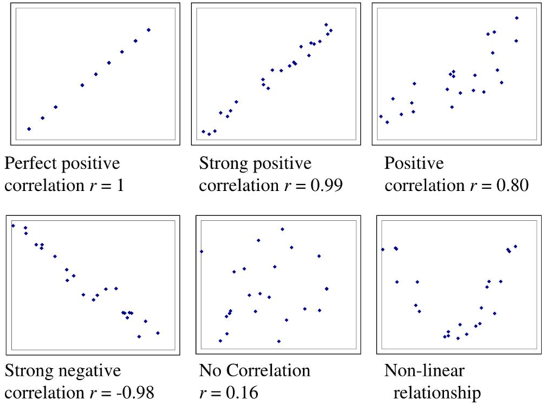

$r^{2}$, the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

Example: The height and weight of a set of runners have a correlation coefficient of r = 0.77.  The $r^{2}$ value is thus 0.77 * 0.77, or 0.59. This means that 59% of the runners’ heights can be explained by the relationship between height and weight. It also means that 41% of the variations in weight cannot be explained by the relationship between height and weight.

**Gotchas**

- Correlation is not causation. For instance, there is a strong correlation ($r^{2}$ = 0.92) between PhD’s awarded in civil engineering and US per-captia consumption of mozzarella. ([Example from stats basics](https://www.spcforexcel.com/knowledge/basic-statistics/just-because-there-is-a-correlation))

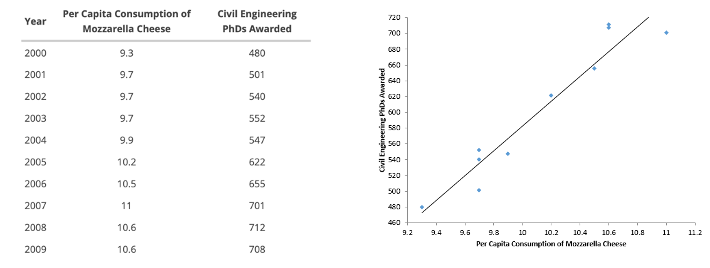

- Watch out for data that come from averages. Averages suppress individual differences (e.g. points far from the regression line).  This can make correlations seem stronger than they really are.

- Non-linear correlations can still exist, but not be modeled by a linear correlation test. For instance, logarithmic correlations are common.

Alright, let's look at an example.  We're going load two data sets, one that contains obesity estimates by census tract.  The other, the fast food restraunts in the city, indexed with census tract.

In [70]:
df_obesity = pd.read_csv("files/obesity-ac-2006-2010censustracts.csv")
df_obesity

,stname,tractfips,2000 Tract,2010 Tract,MUNICIPALITY,Municipality,City Neighborhood,2006-2010 estimate of obesity
0,Pennsylvania,42003010300,10300,NaN,PITTSBURGH,Pittsburgh,Bluff,0.246936
1,Pennsylvania,42003020100,20100,NaN,PITTSBURGH,Pittsburgh,Central Business District,0.668012
2,Pennsylvania,42003020300,20300,NaN,PITTSBURGH,Pittsburgh,Strip District,0.369996
3,Pennsylvania,42003030500,30500,NaN,PITTSBURGH,Pittsburgh,Crawford Roberts,0.488691
4,Pennsylvania,42003040200,40200,NaN,PITTSBURGH,Pittsburgh,West oakland,0.366391
...,...,...,...,...,...,...,...,...
411,Pennsylvania,42003980600,210800,980600,PITTSBURGH,Pittsburgh,Chateau,0.439386
412,Pennsylvania,42003980700,192100,980700,PITTSBURGH,Pittsburgh,South Shore,0.354375
413,Pennsylvania,42003981200,220500,563200 & 981200,PITTSBURGH,Pittsburgh,North Shore,0.121487
414,Pennsylvania,42003981800,120300,NaN,PITTSBURGH,Pittsburgh,Lincoln-Lemington-Belmar,0.574293


In [71]:
df_fast_food_tract = pd.read_csv("files/fastfoodalleghenycountyupdatexy2plustract.csv")
df_fast_food_tract

,Unnamed: 0,Name,Legal Name,Start Date,Street Number,Street Name,ZIP Code,Lat,Lon,Category,tract
0,0,Adrian's Pizza,NaN,11/7/2014,605,Thompson Run Rd,15237,40.539465,-79.990764,Take Out,429202.0
1,1,Adrian's Pizza Express,Rock Enterprises Inc,4/22/2004,7824,Perry Hwy,15237,40.551219,-80.037362,Take Out,429400.0
2,2,Allegheny Sandwich Shop,NaN,2/24/1997,414,Grant St,15219,40.438110,-79.996860,NO Dollar Menu,20100.0
3,3,Allegheny Sandwich Shoppe #3,Allegheny Sandwich Shoppe Inc,11/9/2001,440,Ross St,15219,40.438514,-79.995330,NO Dollar Menu,20100.0
4,4,Amili's Pizzeria,NaN,2/26/1999,1021,Brownsville Rd,15210,40.406082,-79.991863,Take Out,290200.0
...,...,...,...,...,...,...,...,...,...,...,...
833,833,Wendy's Old Fashioned Hamburgers #2360,Primary Aim LLC,12/18/2015,8703,University Blvd,15108,40.506020,-80.222562,Dollar Menu,NaN
834,834,Wing Stop,Wing Stop Corp,1/15/2015,1324,Carson St,15203,40.428626,-79.984257,Take Out,170200.0
835,835,Wing Stop #827,Pittsburgh Wings #1 LLC,10/28/2015,13,Foster Ave,15205,40.441096,-80.069146,Take Out,465600.0
836,836,Wings Over Pittsburgh,Pittwings LLC,7/5/2013,2525,Carson St,15203,40.427812,-79.969116,Take Out,NaN


On this last data set we need to do some fitness, changing the tract column into an `integer` so the merge can be performed correctly.

In [72]:
df_fast_food_tract = df_fast_food_tract.dropna(subset=['tract']).copy()
df_fast_food_tract['tract'] = df_fast_food_tract['tract'].astype('int32')

In [73]:
df_fast_food_tract

,Unnamed: 0,Name,Legal Name,Start Date,Street Number,Street Name,ZIP Code,Lat,Lon,Category,tract
0,0,Adrian's Pizza,NaN,11/7/2014,605,Thompson Run Rd,15237,40.539465,-79.990764,Take Out,429202
1,1,Adrian's Pizza Express,Rock Enterprises Inc,4/22/2004,7824,Perry Hwy,15237,40.551219,-80.037362,Take Out,429400
2,2,Allegheny Sandwich Shop,NaN,2/24/1997,414,Grant St,15219,40.438110,-79.996860,NO Dollar Menu,20100
3,3,Allegheny Sandwich Shoppe #3,Allegheny Sandwich Shoppe Inc,11/9/2001,440,Ross St,15219,40.438514,-79.995330,NO Dollar Menu,20100
4,4,Amili's Pizzeria,NaN,2/26/1999,1021,Brownsville Rd,15210,40.406082,-79.991863,Take Out,290200
...,...,...,...,...,...,...,...,...,...,...,...
831,831,Wendy's Old-Fashioned Hamburgers #541,Primary Aim LLC,1/12/2016,2280,Lebanon Church Rd,15122,40.348406,-79.939763,Dollar Menu,488600
832,832,Wendy's Old Fashioned Hamburgers #574,Primary Aim LLC,10/19/2015,10810,Perry Hwy,15090,40.615661,-80.054801,Dollar Menu,409000
834,834,Wing Stop,Wing Stop Corp,1/15/2015,1324,Carson St,15203,40.428626,-79.984257,Take Out,170200
835,835,Wing Stop #827,Pittsburgh Wings #1 LLC,10/28/2015,13,Foster Ave,15205,40.441096,-80.069146,Take Out,465600


Now, more fitness...  To perform the correlation calculation we need counts of fast food joints per tract.  We can do this by collapsing in a `groupby` on tract and asking for the `count()`.

In [74]:
df_fast_food_tract_count = df_fast_food_tract.groupby('tract').count()
df_fast_food_tract_count

,Unnamed: 0,Name,Legal Name,Start Date,Street Number,Street Name,ZIP Code,Lat,Lon,Category
tract,,,,,,,,,,
10300,3,3,2,3,3,3,3,3,3,3
20100,61,61,57,61,61,61,61,61,61,61
20300,5,5,5,5,5,5,5,5,5,5
30500,1,1,0,1,1,1,1,1,1,1
40300,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...
551300,1,1,1,1,1,1,1,1,1,1
551900,3,3,3,3,3,3,3,3,3,3
560400,2,2,2,2,2,2,2,2,2,2


We can also drop off the columns we don't need and no longer make sense.

In [75]:
df_fast_food_tract_count = df_fast_food_tract_count.drop(['Name', 'Street Name', 'Legal Name', 'Start Date', 'Street Number', 'ZIP Code', 'Lat', 'Lon', 'Category'], axis=1).rename(columns={'Unnamed: 0' : 'count'})
df_fast_food_tract_count

,count
tract,
10300,3
20100,61
20300,5
30500,1
40300,3
...,...
551300,1
551900,3
560400,2


Now we can merge the data together on tract.

In [76]:
df_merged = pd.merge(df_obesity, df_fast_food_tract_count, left_on='2000 Tract', right_on = 'tract', how='inner')
df_merged

,stname,tractfips,2000 Tract,2010 Tract,MUNICIPALITY,Municipality,City Neighborhood,2006-2010 estimate of obesity,count
0,Pennsylvania,42003010300,10300,NaN,PITTSBURGH,Pittsburgh,Bluff,0.246936,3
1,Pennsylvania,42003020100,20100,NaN,PITTSBURGH,Pittsburgh,Central Business District,0.668012,61
2,Pennsylvania,42003020300,20300,NaN,PITTSBURGH,Pittsburgh,Strip District,0.369996,5
3,Pennsylvania,42003030500,30500,NaN,PITTSBURGH,Pittsburgh,Crawford Roberts,0.488691,1
4,Pennsylvania,42003040400,40400,NaN,PITTSBURGH,Pittsburgh,North oakland,0.155867,5
...,...,...,...,...,...,...,...,...,...
187,Pennsylvania,42003564400,504400,5644,NORTH VERSAILLES,North Versailles,NaN,0.294694,6
188,Pennsylvania,42003980600,210800,980600,PITTSBURGH,Pittsburgh,Chateau,0.439386,3
189,Pennsylvania,42003980700,192100,980700,PITTSBURGH,Pittsburgh,South Shore,0.354375,1
190,Pennsylvania,42003981200,220500,563200 & 981200,PITTSBURGH,Pittsburgh,North Shore,0.121487,1


Now we have two columns that we can use in a correlation calculation: the count of the fast food joints and the obesity estimate:

In [77]:
df_merged['count']

0       3
1      61
2       5
3       1
4       5
       ..
187     6
188     3
189     1
190     1
191     5
Name: count, Length: 192, dtype: int64

In [78]:
df_merged['2006-2010 estimate of obesity']

0      0.246936
1      0.668012
2      0.369996
3      0.488691
4      0.155867
         ...   
187    0.294694
188    0.439386
189    0.354375
190    0.121487
191    0.138806
Name: 2006-2010 estimate of obesity, Length: 192, dtype: float64

You can use the `stats.pearsonr()` to calculate the r and p values.

The p value is the probability that you would have found the current result if the correlation coefficient were in fact zero . If this probability is lower than the conventional 5% (P<0.05) the correlation coefficient is called statistically significant. ([source](https://www.medcalc.org/manual/correlation.php))

In [79]:
stats.pearsonr(df_merged['count'], df_merged['2006-2010 estimate of obesity'])

(0.16353943520098715, 0.023417552963576047)

Hmmm, let's make sure this checks by looking at the scatter plot of these two values.

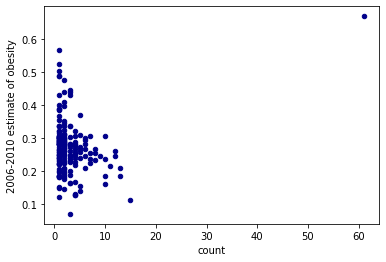

In [80]:
ax1 = df_merged.plot.scatter(x='count', y='2006-2010 estimate of obesity',c='DarkBlue')

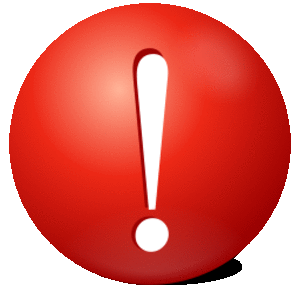

Yikes!  OUTLIER ALERT!

Let's use the z-score method to statistically account for this outlier and boot it.

In [81]:
# compute the zscore of the count column
stats.zscore(df_merged['count'])

0      -0.037700
1      11.624114
2       0.364432
3      -0.439831
4       0.364432
         ...    
187     0.565497
188    -0.037700
189    -0.439831
190    -0.439831
191     0.364432
Name: count, Length: 192, dtype: float64

In [97]:
# remove the row at index position 1
df_merged_no_outlier = df_merged.drop(1, axis=0)

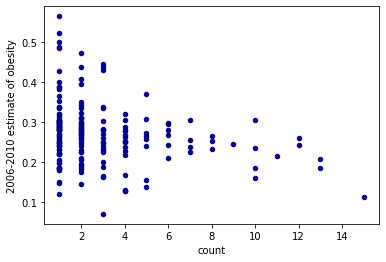

In [98]:
ax2 = df_merged_no_outlier.plot.scatter(x='count', y='2006-2010 estimate of obesity',c='DarkBlue')

Better, now let's run the correlation stat again.

In [99]:
pearsonr = stats.pearsonr(df_merged_no_outlier['count'], df_merged_no_outlier['2006-2010 estimate of obesity'])
pearsonr

(-0.25488361848958085, 0.0003731311483644043)

Ok, now let's calculate the $r^{2}$:

In [100]:
pearsonr[0] ** 2

0.0649656589743422

So because this R-Squared value is close to zero, that indicates there is very little statistical evidence that the number of fast food joints correlates with obesity levels per census tracts in Pittsburgh.

We can also do a little **regression** to visualize this correlation.  This is done with the `stats.linregress()` function:

In [86]:
# calculate a regression line using the linear regression function
slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_no_outlier['count'], df_merged_no_outlier['2006-2010 estimate of obesity'])

Once we have these values, we can plot the regression line on the scatter plot.

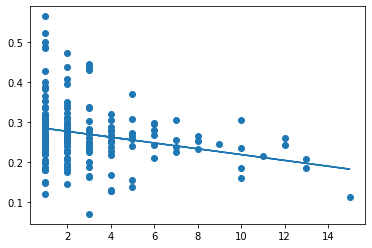

In [103]:
# create a scatter plot of the two variables
plt.scatter(df_merged_no_outlier['count'], df_merged_no_outlier['2006-2010 estimate of obesity'])

x = df_merged_no_outlier['count']

plt.plot(x, intercept + slope * x, '-');

The fact that the best fit line slopes down would indicate a slight negative relationship between the number of fast food restaurants and estimated obesity rates per census tract. 

Ultimately, the relationship between these factors is confounded by a huge number of other variables include race, socioeconomic status, geographic location, zoning, etc. Finding statistically significant results is hard!